In [51]:
# importing the required library
import pandas as pd
import numpy as np
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
import statsmodels.tsa.arima.model as stats
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

In [60]:
## Holt Winter Method
def holtWinterMethod(**kwrgs):
    hwmodel = ExponentialSmoothing(kwrgs['train_data'].payment_value, trend=kwrgs['model_trend'], seasonal=kwrgs['model_seasonality'], seasonal_periods=kwrgs['seasonality_period']).fit()
    test_pred = hwmodel.forecast(len(kwrgs['test_data']))
    if kwrgs['test_flag']==True:
        mean_error = sqrt(mean_squared_error(kwrgs['test_data'], test_pred))
        return mean_error
    else:
        test_pred.index=kwrgs['test_data']
        print(test_pred)
    
# Arima Method 
def arimaMethod(**kwrgs):
    model = stats.ARIMA(kwrgs['train_data'].payment_value, order=kwrgs['best_model'])
    model=model.fit()
    model.summary()

    start = len(kwrgs['train_data'])
    end = len(kwrgs['train_data'])+len(kwrgs['test_data'])-1
    pred = model.predict(start=start, end=end, typ='levels')
    if kwrgs['test_flag']==True:
        mean_error = sqrt(mean_squared_error(kwrgs['test_data'].payment_value,pred))
        return mean_error
    else:
        pred.index=kwrgs['test_data']
        print(pred)

# LSTM Method
def lstmMethod(**kwrgs):
    scaler = MinMaxScaler()
    scaler.fit(kwrgs['train_data'])
    scaled_train = scaler.transform(kwrgs['train_data'])
    
    n_input = kwrgs['seasonality_period']
    n_features = 1
    generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

    # define the model
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # fit model
    model.fit(generator, epochs=kwrgs['epochs'])
    
    test_predictions = []

    first_eval_batch = scaled_train[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))

    for i in range(len(kwrgs['test_data'])):

        #get the prediction value for the first batch
        current_pred = model.predict(current_batch)[0]

        #append the prediction into the array
        test_predictions.append(current_pred)

        #use the prediction to update the batch and remove the first value
        current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

    true_prediction = scaler.inverse_transform(test_predictions)

    if kwrgs['test_flag']==True:
        kwrgs['test_data'].pred = true_prediction
        rmse = sqrt(mean_squared_error(kwrgs['test_data'].payment_value, kwrgs['test_data'].pred))
        return rmse
    else:
        true_prediction.index=kwrgs['test_data']
        print(true_prediction)
    

def forecasting(**kwrgs):
        # Default Model name and Mean error value
        model_name = 'No Model'
        model_mean_error = kwrgs['dataset'].payment_value.mean()

        holt_mean_error = holtWinterMethod(dataset=kwrgs['dataset'], train_data=kwrgs['train_data'], 
                        test_flag=True, test_data=kwrgs['test_data'], seasonality_period=kwrgs['seasonality_period'],
                        model_trend=kwrgs['model_trend'], model_seasonality=kwrgs['model_seasonality']) 

        # Comparing Holt mean error
        if holt_mean_error<model_mean_error:
            model_name = 'Holt Model'
            model_mean_error = holt_mean_error
        
        arima_mean_error = arimaMethod(dataset=kwrgs['dataset'], train_data=kwrgs['train_data'], test_flag=True, 
                    test_data=kwrgs['test_data'], best_model=kwrgs['best_model'])

        # Comparing ARIMA Mean error
        if arima_mean_error<model_mean_error:
            model_name = 'Arima Model'
            model_mean_error = arima_mean_error


        lstm_mean_error = lstmMethod(dataset=kwrgs['dataset'], train_data=kwrgs['train_data'], test_flag=True, 
                    test_data=kwrgs['test_data'], seasonality_period=kwrgs['seasonality_period'],
                    epochs=kwrgs['epochs'])

        # Comparing LSTM Mean error
        if lstm_mean_error<model_mean_error:
            model_name='LSTM Model'
            model_mean_error=lstm_mean_error

        # target data for future prediction
        if kwrgs['level']=='daily':
            target_data = pd.date_range(start=kwrgs['dataset'].tail(1).index.item() + timedelta(days=1), periods = kwrgs['target_data']).to_pydatetime().tolist()
        elif kwrgs['level']=='weekly':
            target_data = pd.DataFrame(pd.date_range(start=kwrgs['dataset'].tail(1).index.item() + timedelta(days=7), periods = kwrgs['target_data']*7).to_pydatetime().tolist(), columns=['date'])
            target_data['date'] = pd.to_datetime((target_data['date'].dt.year).astype(str) + (target_data['date'].dt.week).astype(str) + "1",format='%G%V%w')
            target_data = target_data.drop_duplicates(keep='first')
            target_data = target_data['date'].tolist()
        elif kwrgs['level']=='monthly':
            target_data = pd.DataFrame(pd.date_range(start=kwrgs['dataset'].tail(1).index.item() + timedelta(days=31), periods = kwrgs['target_data']*30).to_pydatetime().tolist(), columns=['date'])
            target_data['date'] = target_data['date'].dt.year.astype('str') + '-' + target_data['date'].dt.month.astype('str') + '-01'
            target_data = target_data.drop_duplicates(keep='first')
            target_data = target_data['date'].tolist()


        # Taking Lowest Mean Error value and executing the required method with target_data
        if model_name=='Holt Model':
            holtWinterMethod(dataset=kwrgs['dataset'], train_data=kwrgs['dataset'], 
                        test_flag=False, test_data=target_data, seasonality_period=kwrgs['seasonality_period'],
                        model_trend=kwrgs['model_trend'], model_seasonality=kwrgs['model_seasonality'])

        elif model_name=='Arima Model':
            arimaMethod(dataset=kwrgs['dataset'], train_data=kwrgs['dataset'], test_flag=False, 
                    test_data=target_data, best_model=kwrgs['best_model'])

        elif model_name=='LSTM Model':
            lstmMethod(dataset=kwrgs['dataset'], train_data=kwrgs['dataset'], test_flag=False, 
                    test_data=target_data, seasonality_period=kwrgs['seasonality_period'],
                    epochs=kwrgs['epochs'])



def preProcessing(**kwrgs):
    # Reading the required data 
    orders = pd.read_csv('orders.csv', parse_dates=['order_purchase_timestamp'])
    orders = orders[orders['order_status'].isin(kwrgs['status'])]

    order_payments = pd.read_csv('order_payments.csv')
    final_order = pd.merge(orders[['order_id', 'order_purchase_timestamp']], order_payments[['order_id', 'payment_value']], on='order_id', how='inner')


    # Level of forecasting (Daily, Weekly, Monthly)
    if kwrgs['level'] == 'daily':
        final_order['date'] = final_order['order_purchase_timestamp'].dt.date
    elif kwrgs['level'] == 'weekly':
        final_order['date'] = pd.to_datetime((final_order['order_purchase_timestamp'].dt.year).astype(str) + (final_order['order_purchase_timestamp'].dt.week).astype(str) + "1",format='%G%V%w')
    elif kwrgs['level'] == 'monthly':
        final_order['date'] = final_order['order_purchase_timestamp'].dt.year.astype('str') + '-' + final_order['order_purchase_timestamp'].dt.month.astype('str') + '-01'
    else:
        print('Please check level input')

    final_order = final_order.groupby(['date'], as_index=True).agg({'payment_value': 'sum'})

    # dicky fullers test
    dftest = adfuller(final_order['payment_value'])
    print("P-value : {0:.2f}".format(dftest[1]))
    
    # Creating train and test data
    test_size = int((kwrgs['test_size']/100)*final_order.shape[0])
    train_data = final_order[:-test_size]
    test_data = final_order[-test_size:]

    # Seasonal Decompose
    seasonal_decompose(train_data, model='additive', period=kwrgs['seasonality_period']).plot()

    # Arima for Best Model
    stepwise_fit = auto_arima(final_order.payment_value, trace=True, suppress_warnings=True)

    return final_order, train_data, test_data


P-value : 0.02
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13884.384, Time=1.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14027.350, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13983.744, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13920.577, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14025.351, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13885.867, Time=0.48 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13885.753, Time=0.30 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=13886.850, Time=1.42 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=13881.735, Time=2.92 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=13885.623, Time=1.79 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=13859.882, Time=4.39 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=13866.649, Time=5.71 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=13865.184, Time=5.20 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=7.21 sec
 ARIMA(4,1

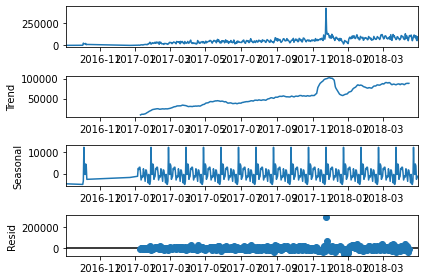

In [61]:
final_order, train_data, test_data = preProcessing(
            status = ['delivered', 'shipped', 'invoiced', 'processing', 'created', 'approved'],
            level = 'daily',
            test_size = 20,
            seasonality_period = 30
)

In [59]:
forecasting(dataset=final_order, train_data=train_data, test_data=test_data, seasonality_period = 30,
            model_trend = 'add', model_seasonality = 'add', best_model = (3,1,3), epochs=50, 
            level = 'daily', target_data = 150
)

Epoch 1/50
461/461 [==============================] - 11s 19ms/step - loss: 0.0039
Epoch 2/50
461/461 [==============================] - 9s 20ms/step - loss: 0.0030
Epoch 3/50
461/461 [==============================] - 9s 19ms/step - loss: 0.0030
Epoch 4/50
461/461 [==============================] - 9s 19ms/step - loss: 0.0030
Epoch 5/50
461/461 [==============================] - 9s 20ms/step - loss: 0.0030
Epoch 6/50
461/461 [==============================] - 9s 19ms/step - loss: 0.0028
Epoch 7/50
461/461 [==============================] - 9s 19ms/step - loss: 0.0029
Epoch 8/50
461/461 [==============================] - 9s 19ms/step - loss: 0.0028
Epoch 9/50
461/461 [==============================] - 6s 13ms/step - loss: 0.0029
Epoch 10/50
461/461 [==============================] - 6s 14ms/step - loss: 0.0028
Epoch 11/50
461/461 [==============================] - 7s 15ms/step - loss: 0.0028
Epoch 12/50
461/461 [==============================] - 7s 15ms/step - loss: 0.0028
Epoch 13/50
